In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix, lil_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import matplotlib.pyplot as plt
import zipfile
import io
from google.colab import files


In [12]:
ratings = files.upload()


movies = files.upload()
ratings = pd.read_csv('u.data', sep='\t', names=['user_id', 'movie_id', 'rating', 'timestamp'])
movies = pd.read_csv('u.item', sep='|', encoding='latin-1',
                     names=['movie_id', 'title', 'release_date', 'video_release', 'imdb_url'] +
                     [f'genre_{i}' for i in range(19)])
ratings = ratings.drop('timestamp', axis=1)
movies = movies[['movie_id', 'title']]


print("Creating user-item matrix...")
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()

ratings['user_idx'] = user_encoder.fit_transform(ratings['user_id'])
ratings['movie_idx'] = movie_encoder.fit_transform(ratings['movie_id'])

num_users = ratings['user_idx'].nunique()
num_movies = ratings['movie_idx'].nunique()


ratings_matrix = lil_matrix((num_users, num_movies))
for _, row in tqdm(ratings.iterrows(), total=len(ratings), desc="Building matrix"):
    ratings_matrix[row['user_idx'], row['movie_idx']] = row['rating']
ratings_matrix = ratings_matrix.tocsr()


print("Splitting into train/test sets...")
train_matrix, test_matrix = train_test_split(ratings_matrix, test_size=0.2, random_state=42)


Saving u.data to u (2).data


Saving u.item to u (2).item
Creating user-item matrix...


Building matrix: 100%|██████████| 100000/100000 [00:04<00:00, 23727.17it/s]


Splitting into train/test sets...


In [4]:
def user_based_recommendation(user_idx, k=20, n_recommendations=10):
    user_similarity = cosine_similarity(train_matrix[user_idx], train_matrix).flatten()
    similar_users = np.argsort(user_similarity)[::-1][1:k+1]
    similarity_weights = user_similarity[similar_users]
    similar_ratings = train_matrix[similar_users].multiply(similarity_weights[:, np.newaxis]).sum(axis=0)
    similar_ratings /= (np.abs(similarity_weights).sum() + 1e-8)
    watched_movies = train_matrix[user_idx].nonzero()[1]
    recommendations = []
    for movie_idx in range(num_movies):
        if movie_idx not in watched_movies and similar_ratings[0, movie_idx] > 0:
            recommendations.append((movie_idx, similar_ratings[0, movie_idx]))
    recommendations.sort(key=lambda x: x[1], reverse=True)
    return [movie_encoder.inverse_transform([movie_idx])[0] for movie_idx, _ in recommendations[:n_recommendations]]

In [5]:
def item_based_recommendation(user_idx, k=20, n_recommendations=10):
    user_ratings = train_matrix[user_idx].toarray().flatten()
    rated_movies = np.where(user_ratings > 0)[0]

    if len(rated_movies) == 0:
        return []
    if not hasattr(item_based_recommendation, 'item_sim'):
        print("Computing item similarity matrix...")
        item_sample = np.random.choice(num_movies, size=min(2000, num_movies), replace=False)
        item_subset = train_matrix[:, item_sample]
        item_based_recommendation.item_sim = cosine_similarity(item_subset.T)
        item_based_recommendation.sampled_items = item_sample
    rated_in_sample = [i for i, movie_idx in enumerate(item_based_recommendation.sampled_items)
                      if movie_idx in rated_movies]

    if not rated_in_sample:
        return []

    scores = np.zeros(len(item_based_recommendation.sampled_items))
    for i in rated_in_sample:

        similar_items = np.argsort(item_based_recommendation.item_sim[i])[::-1][1:k+1]
        for sim_idx in similar_items:
            if user_ratings[item_based_recommendation.sampled_items[sim_idx]] == 0:
                scores[sim_idx] += item_based_recommendation.item_sim[i, sim_idx] * user_ratings[item_based_recommendation.sampled_items[i]]


    top_indices = np.argsort(scores)[::-1][:n_recommendations]
    return [item_based_recommendation.sampled_items[i] for i in top_indices if scores[i] > 0]

In [6]:
def svd_recommendation(user_idx, n_factors=50, n_recommendations=10):
    if not hasattr(svd_recommendation, 'svd_model'):
        print("Training SVD model...")
        svd_recommendation.svd_model = TruncatedSVD(n_components=n_factors, random_state=42)
        svd_recommendation.user_factors = svd_recommendation.svd_model.fit_transform(train_matrix)
        svd_recommendation.item_factors = svd_recommendation.svd_model.components_.T
        svd_recommendation.reconstructed = svd_recommendation.user_factors @ svd_recommendation.item_factors.T

    pred_ratings = svd_recommendation.reconstructed[user_idx]
    watched_movies = train_matrix[user_idx].nonzero()[1]
    recommendations = []
    for movie_idx in range(num_movies):
        if movie_idx not in watched_movies:
            recommendations.append((movie_idx, pred_ratings[movie_idx]))
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return [movie_encoder.inverse_transform([movie_idx])[0] for movie_idx, _ in recommendations[:n_recommendations]]

In [7]:
def precision_at_k(user_idx, recommendations, test_ratings, k=10):
    actual_positives = set(test_ratings[user_idx].nonzero()[1])
    top_k = set(recommendations[:k])
    relevant = len(actual_positives & top_k)

    return relevant / k if k > 0 else 0

def evaluate_methods(n_users=100, k=10):
    """Evaluate all recommendation methods on a sample of users"""
    results = {
        'user_based': [],
        'item_based': [],
        'svd': []
    }
    test_user_indices = []
    for user_idx in range(test_matrix.shape[0]):
        if test_matrix[user_idx].nnz >= 5:
            test_user_indices.append(user_idx)

    if len(test_user_indices) > n_users:
        test_user_indices = np.random.choice(test_user_indices, size=n_users, replace=False)

    print(f"Evaluating on {len(test_user_indices)} users...")

    for user_idx in tqdm(test_user_indices, desc="Evaluating methods"):

        user_recs = user_based_recommendation(user_idx, n_recommendations=k)
        results['user_based'].append(precision_at_k(user_idx, user_recs, test_matrix, k))
        item_recs = item_based_recommendation(user_idx, n_recommendations=k)
        if item_recs:
            results['item_based'].append(precision_at_k(user_idx, item_recs, test_matrix, k))
        else:
            results['item_based'].append(0.0)

        svd_recs = svd_recommendation(user_idx, n_recommendations=k)
        results['svd'].append(precision_at_k(user_idx, svd_recs, test_matrix, k))

    return {method: (np.mean(precisions), precisions) for method, precisions in results.items()}

In [8]:
def sample_recommendations(user_id, n=10):
    try:
        user_idx = user_encoder.transform([user_id])[0]
    except:
        print(f"User ID {user_id} not found. Selecting random user.")
        user_idx = np.random.randint(0, num_users)
        user_id = user_encoder.inverse_transform([user_idx])[0]

    print(f"\nRecommendations for user {user_id}:")

    rated_movies = ratings[ratings['user_id'] == user_id].merge(movies, on='movie_id')
    print("\nUser's top-rated movies:")
    print(rated_movies.sort_values('rating', ascending=False).head(5)[['title', 'rating']])
    user_recs = user_based_recommendation(user_idx, n_recommendations=n)
    print("\nUser-based recommendations:")
    print(movies[movies['movie_id'].isin(user_recs)]['title'])

    item_recs = item_based_recommendation(user_idx, n_recommendations=n)
    if item_recs:
        print("\nItem-based recommendations:")
        print(movies[movies['movie_id'].isin(item_recs)]['title'])
    else:
        print("\nNo item-based recommendations available")
    svd_recs = svd_recommendation(user_idx, n_recommendations=n)
    print("\nSVD recommendations:")
    print(movies[movies['movie_id'].isin(svd_recs)]['title'])

In [9]:
def plot_results(results):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    methods = list(results.keys())
    means = [results[method][0] for method in methods]
    plt.bar(methods, means, color=['blue', 'green', 'red'])
    plt.title('Mean Precision@10')
    plt.ylabel('Precision')
    plt.ylim(0, 0.5)
    plt.subplot(1, 2, 2)
    plt.boxplot([results[method][1] for method in methods], labels=methods)
    plt.title('Precision@10 Distribution')
    plt.ylabel('Precision')

    plt.tight_layout()
    plt.show()

Evaluating on 189 users...


Evaluating methods:   0%|          | 0/189 [00:00<?, ?it/s]

Computing item similarity matrix...
Training SVD model...


Evaluating methods: 100%|██████████| 189/189 [00:10<00:00, 17.82it/s]
/tmp/ipython-input-9-3687578196.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([results[method][1] for method in methods], labels=methods)



Evaluation Results (Precision@10):
USER_BASED: 0.1429
ITEM_BASED: 0.2995
SVD: 0.1349


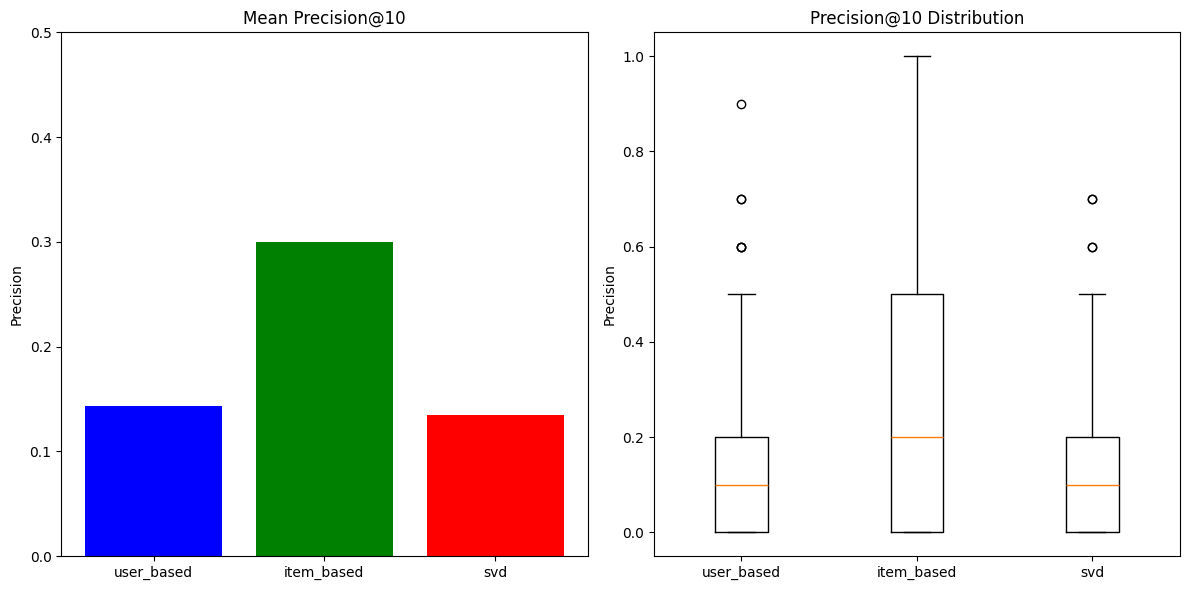


Recommendations for user 617:

User's top-rated movies:
                                                 title  rating
19                                       Psycho (1960)       5
104  Paradise Lost: The Child Murders at Robin Hood...       5
94                                  Raging Bull (1980)       5
92                                 Shining, The (1980)       5
83                 Faster Pussycat! Kill! Kill! (1965)       5

User-based recommendations:
143                           Die Hard (1988)
167    Monty Python and the Holy Grail (1974)
171           Empire Strikes Back, The (1980)
180                 Return of the Jedi (1983)
182                              Alien (1979)
Name: title, dtype: object

Item-based recommendations:
67              Crow, The (1994)
170          Delicatessen (1991)
181            GoodFellas (1990)
202            Unforgiven (1992)
208    This Is Spinal Tap (1984)
Name: title, dtype: object

SVD recommendations:
52           Natural Born Killers (1

In [13]:
if __name__ == "__main__":
    evaluation_results = evaluate_methods(n_users=200, k=10)

    print("\nEvaluation Results (Precision@10):")
    for method, (mean_precision, _) in evaluation_results.items():
        print(f"{method.upper()}: {mean_precision:.4f}")
    plot_results(evaluation_results)
    sample_user = ratings['user_id'].sample(1).values[0]
    sample_recommendations(sample_user, n=5)